**Goal**<br>
For a labeled dataset $\{x_i,y_i\}_{i=1}^N$, the Hessian of the loss is defined as

$H = \sum_{i=1}^N \frac{\partial^2 \mathcal{}(f(x_i;\theta),y_i)}{\partial \theta^2} \in \mathbb{R}^{p \times p}.$

The goal of this exercise is to train a neural network and to calculate---at the beginning and at the end of training---the spectrum of the Hessian:

$\{\lambda_i(H) \ : \ i=1,\dots,p\}$.

Our implementation will have a high runtime complexity. We will therefore:
* train a small network;
* on a subset of the MNIST dataset;
* and down-sample the images to $8 \times 8$ pixels.

*Before you start, make sure to change the runtime type to include a GPU!*

<br>

**Task 1 (adding 2 lines of code)**<br>
Implement the function *Hessian_vector_multiplication* which obtains as input a vector $v \in \mathbb{R}^p$ and calculates the Hessian vector multiplication, $H v \in \mathbb{R}^{p}$.

Hints:
* read carefully the documentation of the function *torch.autograd.grad* in the following link: https://pytorch.org/docs/stable/autograd.html
* use the function *torch.autograd.grad* **twice**:
    1. first calculate the gradient, $\frac{\partial \mathcal{L}(f(x_i;\theta),y_i)}{\partial \theta}$
    2. then calculate the gradient of the gradient, i.e., the Hessian $\frac{\partial^2 \mathcal{L}(f(x_i;\theta),y_i)}{\partial \theta^2}$, in the direction of the vector $v$.
* use the functions *list_to_vector* and *vector_to_list*

<br>

**Task 2 (adding 3 lines of code)**<br>
Implement the function *get_Hessian_column*, which calculates the $i$-th column in the Hessian, using the function *Hessian_vector_multiplication*.

Hints:
* to extract the $i$-th column of a matrix, one can multiply the matrix by a one-hot vector.
* use the variable p

<br>

**Task 3 (adding 1 line of code)**<br>
Construct the Hessian matrix using the function *get_Hessian_column*.

Hints:
* use the function *torch.cat*

<br>


**Task 4 (thinking)**<br>
How does the spectrum change throughout the epochs of SGD?

<br>

**Submission**<br>
*   Download your code by clicking File -> Download .ipynb
*   Submit your downloaded code on Quercus together with a PDF file of your code.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from scipy.sparse.linalg import svds

%matplotlib inline

In [ ]:
# hyperparameters
device          = "cuda"
epochs          = 100
lr              = 0.1
batch_size      = 128
momentum        = 0.9
weight_decay    = 5e-4

In [ ]:
# model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(8**2, 10)
        self.fc2 = nn.Linear(10, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.fc2(F.relu(self.fc1(x)))

# dataset
transform = transforms.Compose([transforms.Resize(8),
                                transforms.ToTensor(),
                                transforms.Normalize(0.1307,0.3081)])

dataset = datasets.MNIST('../data', download=True, train=True, transform=transform)

# subsample dataset
subset = torch.utils.data.Subset(dataset, range(0, len(dataset), 100))

train_loader = torch.utils.data.DataLoader(subset, batch_size=batch_size,
                                           shuffle=True, drop_last=True)

train_loader_2 = torch.utils.data.DataLoader(subset, batch_size=batch_size,
                                             shuffle=True, drop_last=False)

# loss function
loss_function = nn.CrossEntropyLoss()

loss_function_2 = nn.CrossEntropyLoss(reduction='sum')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:3415.)


Train		Epoch: 1 	Batch 1/4 (25%) 	Batch Loss: 2.332540 	Batch Accuracy: 5.468750
Train		Epoch: 1 	Batch 2/4 (50%) 	Batch Loss: 2.306489 	Batch Accuracy: 8.203125
Train		Epoch: 1 	Batch 3/4 (75%) 	Batch Loss: 2.295761 	Batch Accuracy: 8.854167
Train		Epoch: 1 	Batch 4/4 (100%) 	Batch Loss: 2.274896 	Batch Accuracy: 8.984375
Train		Epoch: 2 	Batch 1/4 (25%) 	Batch Loss: 2.246039 	Batch Accuracy: 14.843750
Train		Epoch: 2 	Batch 2/4 (50%) 	Batch Loss: 2.207152 	Batch Accuracy: 14.843750
Train		Epoch: 2 	Batch 3/4 (75%) 	Batch Loss: 2.165953 	Batch Accuracy: 21.093750
Train		Epoch: 2 	Batch 4/4 (100%) 	Batch Loss: 2.128078 	Batch Accuracy: 23.437500
Train		Epoch: 3 	Batch 1/4 (25%) 	Batch Loss: 2.057085 	Batch Accuracy: 38.281250
Train		Epoch: 3 	Batch 2/4 (50%) 	Batch Loss: 2.045124 	Batch Accuracy: 35.156250
Train		Epoch: 3 	Batch 3/4 (75%) 	Batch Loss: 1.973678 	Batch Accuracy: 35.937500
Train		Epoch: 3 	Batch 4/4 (100%) 	Batch Loss: 1.979944 	Batch Accuracy: 34.570312
Train		Epoch: 4 	

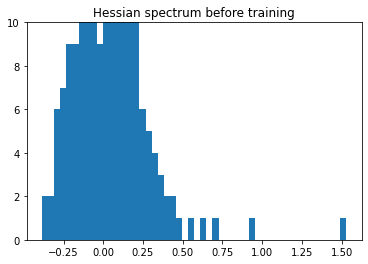

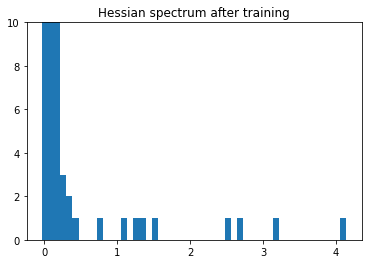

In [ ]:
# initialize model
model = MLP().to(device)

# optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay)

# very useful functions
def list_to_vector(list_):
    return torch.cat([x.view(-1) for x in list_])

def vector_to_list(vector):
    list_ = []
    counter = 0
    for param in list(model.parameters()):
        list_.append(vector[counter:counter+torch.numel(param)].view(param.shape))
        counter += torch.numel(param)
    return list_

# total_number_of_parameters
p = sum(param.numel() for param in model.parameters() if param.requires_grad)


def calculate_Hessian_spectrum(title):
    def Hessian_vector_multiplication(vector):
        Hv = 0
        N = 0
        for images, labels in train_loader_2:
            N += images.shape[0]
            images, labels = images.to(device), labels.to(device) 

            # images (128, 8^2)
            # labels (128,)
            
            logits = model(images) # (128, 10)
            loss = loss_function_2(logits, labels)

            # TASK 1: ADD CODE HERE
            gradient = torch.autograd.grad(outputs=loss,
                                           inputs=model.parameters(),
                                           grad_outputs=None,
                                           create_graph=True)
            gradient = list_to_vector(gradient)

            hessian =  torch.autograd.grad(outputs=gradient,
                                           inputs=model.parameters(),
                                           grad_outputs=vector)
            Hv += list_to_vector(hessian)

        return Hv/N

    def get_Hessian_column(i):
        # TASK 2: ADD CODE HERE
        v = torch.zeros(p).to(device)
        v[i] = 1.0

        column = Hessian_vector_multiplication(v)
        return column

    # TASK 3: ADD CODE HERE
    H = torch.cat([get_Hessian_column(i) for i in range(p)]).view(p, p)


    # plot spectrum
    plt.figure()
    eigval,_ = torch.eig(H)
    plt.hist(eigval[:,0].detach().cpu(), bins=50)
    plt.ylim([0,10])
    plt.title(title)


calculate_Hessian_spectrum('Hessian spectrum before training')

# iterate over epochs
for epoch in range(1, epochs+1):
    model.train()

    accuracy = 0
    N = 0

    # iterate over train data
    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        images, labels = images.to(device), labels.to(device)
        
        # forward pass
        logits = model(images)
        loss = loss_function(logits, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(logits,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]

        print('Train\t\tEpoch: {} \t'
              'Batch {}/{} ({:.0f}%) \t'
              'Batch Loss: {:.6f} \t'
              'Batch Accuracy: {:.6f}'.format(
                  epoch,
                  batch_idx,
                  len(train_loader),
                  100. * batch_idx / len(train_loader),
                  loss.item(),
                  100. * accuracy/N))
        
calculate_Hessian_spectrum('Hessian spectrum after training')

# TASK 4: 
# Throughout the epochs of SGD, the bulk of the Hessian becomes concetrated 
# around 0, more outliers are emerge from the bulk, and the outliers increase in
# magnitude.